This notebook is a summary from below sources:
1. https://medium.com/swlh/python-nlp-tutorial-information-extraction-and-knowledge-graphs-43a2a4c4556c
2. https://github.com/bdmarius/python-knowledge-graph/blob/master/knowledgegraph.py

Steps on creating simple knowledge graph:
- Import our dependencies
- Use spaCy to split the text in sentences
- For each sentence, use spaCy to figure out what kind of word is every word in that sentence: is it a subject, an object, a predicate and so on
- Use the information from above to figure out where in the triple we should put a word
- Finally build the triples
- Build and show the knowledge graph

In [4]:
# Import library
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

In [6]:
text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
        "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
        "the North Sea, London has been a major settlement for two millennia. " \
        "Londinium was founded by the Romans. The City of London, " \
        "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
        "the Square Mile − retains boundaries that follow closely its medieval limits." \
        "The City of Westminster is also an Inner London borough holding city status. " \
        "Greater London is governed by the Mayor of London and the London Assembly." \
        "London is located in the southeast of England." \
        "Westminster is located in London." \
        "London is the biggest city in Britain. London has a population of 7,172,036."

text

"London is the capital and largest city of England and the United Kingdom. Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia. Londinium was founded by the Romans. The City of London, London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits.The City of Westminster is also an Inner London borough holding city status. Greater London is governed by the Mayor of London and the London Assembly.London is located in the southeast of England.Westminster is located in London.London is the biggest city in Britain. London has a population of 7,172,036."

# **1. Functions that will be Applied to Make Knowledge Graph**



#### **1.1 Splitting Text into Sentences**

In [8]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

In [9]:
sentences = getSentences(text)
sentences

['London is the capital and largest city of England and the United Kingdom.',
 'Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia.',
 'Londinium was founded by the Romans.',
 "The City of London, London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits.",
 'The City of Westminster is also an Inner London borough holding city status.',
 'Greater London is governed by the Mayor of London and the London Assembly.',
 'London is located in the southeast of England.',
 'Westminster is located in London.',
 'London is the biggest city in Britain.',
 'London has a population of 7,172,036.']

#### **1.2. Getting Token Dependancy**

In [10]:
def printToken(token):
    print(token.text, "->", token.dep_)

In [18]:
for token in nlp(text[:100]):
    printToken(token)

London -> nsubj
is -> ROOT
the -> det
capital -> attr
and -> cc
largest -> amod
city -> conj
of -> prep
England -> pobj
and -> cc
the -> det
United -> compound
Kingdom -> conj
. -> punct
Standing -> ROOT
on -> prep
the -> det
River -> compound
Tham -> pobj


#### **1.3 Checking Whether a Token is Categorized into Desired Dependancy Tag (Relation)**

In [19]:
def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

In [31]:
for token in nlp(text[:50]):
    print(token.text, '--', isRelationCandidate(token), '--', token.dep_)

London -- False -- nsubj
is -- True -- ROOT
the -- False -- det
capital -- True -- attr
and -- False -- cc
largest -- True -- amod
city -- False -- conj
of -- False -- prep
England -- False -- pobj


#### **1.4 Checking Whether a Token is Categorized into Desired Dependancy Tag (Entities: subject and object)**

In [32]:
def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

In [33]:
for token in nlp(text[:50]):
    print(token.text, '--', isConstructionCandidate(token), '--', token.dep_)

London -- False -- nsubj
is -- False -- ROOT
the -- False -- det
capital -- False -- attr
and -- False -- cc
largest -- True -- amod
city -- True -- conj
of -- True -- prep
England -- False -- pobj


#### **1.5 Pairing Object and Subject**

How it works:
- Taking every token(meaning every word and every punctuation mark) and putting it in a category.
- After we have reached the end of a sentence, we clear up the whitespaces which might have remained and then we’re good to go, we have obtained a triple.
- We can use this and the networkx and pyplot libraries to build the Knowledge Graph.

In [44]:
def appendChunk(original, chunk):
    return original + ' ' + chunk

def processSubjectObjectPairs(tokens):
    #Chunk1
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

#### **1.6 Knowledge Graph Vizualisation**

In [63]:
def printGraph(triples, length=20, width=10):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(length, width))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

# **2. Applying it to Dataset**

In [65]:
# Applying to the example text
if __name__ == "__main__":

    text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."

    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

London is the capital and largest city of England and the United Kingdom. Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia. Londinium was founded by the Romans. The City of London, London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits.The City of Westminster is also an Inner London borough holding city status. Greater London is governed by the Mayor of London and the London Assembly.London is located in the southeast of England.Westminster is located in London.London is the biggest city in Britain. London has a population of 7,172,036.
London -> nsubj
is -> ROOT
the -> det
capital -> attr
and -> cc
largest -> amod
city -> conj
of -> prep
England -> pobj
and -> cc
the -> det
United -> compound
Kingdom -> conj
. -> punct
London , be capital la

In [69]:
# printing the triples
import pandas as pd
pd.DataFrame(triples, columns=['Subject', 'Relation', 'Object'])

,Subject,Relation,Object
0,London,be capital large,England
1,London,be major settlement,Thames east England head estuary Sea millennia
2,Londinium,found by,Romans
3,City that,ancient square retain medieval,London miles − boundaries limits
4,City,be borough,Westminster status
5,London,govern by,Mayor London
6,London,locate,southeast England
7,Westminster,locate,London
8,London,be big city,Britain
9,London,have,"population 7,172,036"


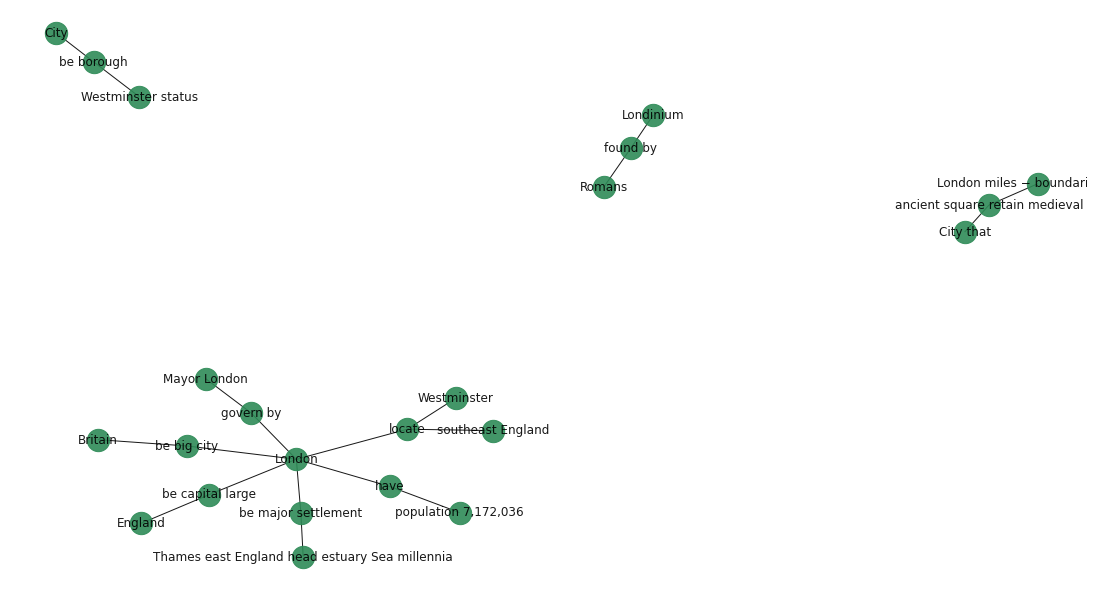

In [64]:
printGraph(triples, 15, 8)